# **3 Types of Segmentatio**

In [ ]:
!pip install torch torchvision matplotlib opencv-python

In [ ]:
# 1. Imports
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

# 2. Load a sample traffic image
# You can upload your own traffic image in Colab or use a URL
img_path = "/content/traffic.jpg"
img = Image.open(img_path).convert("RGB")

# Transform for PyTorch models
transform = transforms.Compose([
    transforms.ToTensor()
])

img_tensor = transform(img).unsqueeze(0)

# Helper function to visualize masks
def show_mask(mask, title="Mask"):
    plt.imshow(mask)
    plt.axis("off")
    plt.title(title)
    plt.show()

# **A. Semantic Segmentation (DeepLabV3)**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:02<00:00, 56.6MB/s]


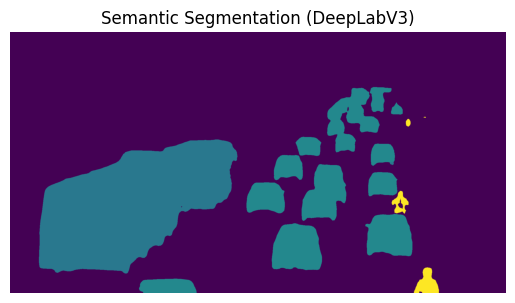

In [ ]:
# Load pretrained DeepLabV3
semantic_model = models.segmentation.deeplabv3_resnet50(pretrained=True)
semantic_model.eval()

# Run inference
with torch.no_grad():
    output = semantic_model(img_tensor)['out'][0]

# Convert to mask
semantic_mask = output.argmax(0).byte().cpu().numpy()

# Display semantic segmentation mask
show_mask(semantic_mask, title="Semantic Segmentation (DeepLabV3)")


# **B. Instance Segmentation (Mask R-CNN)**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 157MB/s]


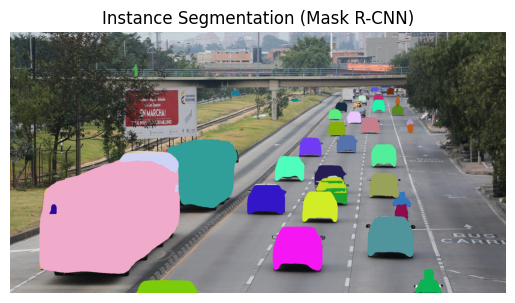

In [ ]:
# Load pretrained Mask R-CNN
instance_model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
instance_model.eval()

# Run inference
with torch.no_grad():
    outputs = instance_model(img_tensor)

# Take first image predictions
masks = outputs[0]['masks']  # [N,1,H,W]
boxes = outputs[0]['boxes']
labels = outputs[0]['labels']
scores = outputs[0]['scores']

# Filter by confidence > 0.5
threshold = 0.5
masks_filtered = masks[scores>threshold]
boxes_filtered = boxes[scores>threshold]

# Visualize masks over image
img_np = np.array(img)
for mask in masks_filtered:
    mask_np = mask[0].mul(255).byte().cpu().numpy()
    color = np.random.randint(0,255,(3,))
    img_np[mask_np>128] = color

plt.imshow(img_np)
plt.axis("off")
plt.title("Instance Segmentation (Mask R-CNN)")
plt.show()


# **C. Detectron2 for Panoptic Segmentation**

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-74gvso3o
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-74gvso3o
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6352441 sha256=4fde090ad335e4b744b9756005652f34dc4e53e5af04ab59211473043f7d0c80
  Stored in directory: /tmp/pip-ephem-wheel-cache-x66896ai/wheels/d3/6e/bd/1969578f1456a6be2

model_final_c10459.pkl: 184MB [00:01, 100MB/s]                            
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


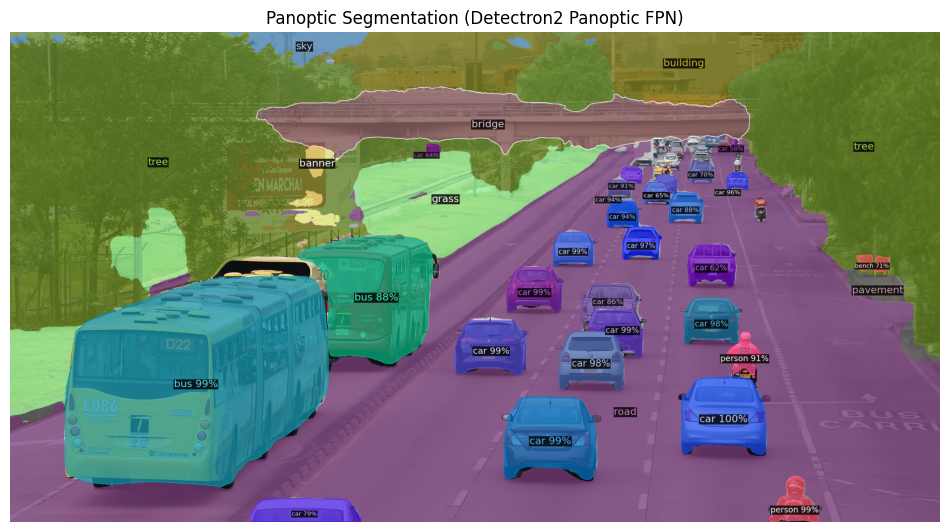

In [ ]:
# 2. Imports
import cv2
import torch
import numpy as np
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from PIL import Image

# 3. Load traffic image
img_path = "/content/traffic.jpg"
img_cv = cv2.imread(img_path)  # OpenCV loads BGR by default

# 4. Configure Detectron2 panoptic model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

# 5. Run inference
panoptic_output = predictor(img_cv)["panoptic_seg"]  # returns (mask tensor, segments_info)
panoptic_mask, segments_info = panoptic_output

# 6. Visualize
v = Visualizer(img_cv[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
out = v.draw_panoptic_seg_predictions(panoptic_mask.to("cpu"), segments_info)
result_img = out.get_image()

# 7. Show image
plt.figure(figsize=(12,8))
plt.imshow(result_img)
plt.axis("off")
plt.title("Panoptic Segmentation (Detectron2 Panoptic FPN)")
plt.show()
